In [1]:
import errno
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.models import load_model
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

import csv
import glob
import gdal

from datetime import datetime

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.5


In [2]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

K.set_image_data_format('channels_first')

N_Cls = 1
data_base_dir = "/home/ubuntu/data/"
inDir = './'
mkdir_p(inDir + '/data')
out_dir = 'output/'
mkdir_p(out_dir)

print(os.getcwd())
DF = pd.read_csv(data_base_dir+'train_wkt_v4_TREES.csv')
val_DF = pd.read_csv(data_base_dir+'val_wkt_v4_TREES.csv')
GS = pd.read_csv(data_base_dir+'grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(data_base_dir+'sample_submission.csv')

ISZ = 160
smooth = 1e-12

EPSILON = 2  # polygon edge smoothing factor (higher=less nodes, i.e. less detail)
MIN_AREA = 5.  # smallest area a polygon can be

val_img_names = ["6010_4_4", "6070_2_3", "6100_2_3", "6140_1_2", "6110_4_0"]

/home/ubuntu/git/kaggle-dstl/keras2-baseline-improvements


# Image preprocessing

## Create indexes (all test/train/val TIFFs)

In [76]:
def ndwi_calc(green, nir):
    ndwi = ((green - nir) / (green + nir))
    return ndwi

In [84]:
def get_bands(src):
    red = src.GetRasterBand(5)
    nir = src.GetRasterBand(7)
    blue = src.GetRasterBand(2)

    r_arr = red.ReadAsArray()
    nir_arr = nir.ReadAsArray()
    b_arr = blue.ReadAsArray()

    r_arr = r_arr.astype(np.float32)
    nir_arr = nir_arr.astype(np.float32)
    b_arr = b_arr.astype(np.float32)
    
    green = src.GetRasterBand(3)
    g_arr = green.ReadAsArray()
    g_arr = g_arr.astype(np.float32)

    return r_arr, nir_arr, b_arr, g_arr


def ndvi_calc(red, nir):
    # https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index
    return ((nir - red) / (nir + red))


def evi_calc(r_arr, nir_arr, b_arr,
             canopy_background_adjustment,
             coefficient_1_of_the_aerosol_resistance_term,
             coefficient_2_of_the_aerosol_resistance_term,
             gain_factor):
    # https://en.wikipedia.org/wiki/Enhanced_vegetation_index
    L = canopy_background_adjustment
    C1 = coefficient_1_of_the_aerosol_resistance_term
    C2 = coefficient_2_of_the_aerosol_resistance_term
    G = gain_factor
    return G * (nir_arr - r_arr) / (nir_arr + C1*r_arr - C2*b_arr + L)


def get_scalers(x_max, y_min, im_size):
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min


# "With the value for L used, this is essentially the same computation as NDVI - hence commented out.
# (indeed, the visualisation of the index bands indicate the similarity)."
def savi_calc(r_arr, nir_arr, canopy_background_adjustment_factor):
    # https: // en.wikipedia.org / wiki / Soil - Adjusted_Vegetation_Index   
    L = canopy_background_adjustment_factor
    return ((1 + L)*(nir_arr - r_arr)) / (nir_arr + r_arr + L)


def get_xmax_ymin(imageid):
    for _im_id, _x, _y in csv.reader(open(data_base_dir + "/grid_sizes.csv")):
        if _im_id == imageid:
            x_max, y_min = float(_x), float(_y)
            return x_max, y_min


def create_indexes(image_id):
#     ndvi_all = []
#     evi_all = []
#     savi_all = []
    
    m_path = data_base_dir + "sixteen_band/{}_M.tif".format(image_id)
    imageid = m_path.split("/")[-1].split("_M.tif")[0]

    src = gdal.Open(m_path)

    r_arr, nir_arr, b_arr, g_arr = get_bands(src)

    im_size = r_arr.shape

    x_max, y_min = get_xmax_ymin(imageid)

    x_scaler, y_scaler = get_scalers(x_max, y_min, im_size)

    ndvi = ndvi_calc(r_arr, nir_arr)
    evi = evi_calc(r_arr, nir_arr, b_arr,
         canopy_background_adjustment=1,
         coefficient_1_of_the_aerosol_resistance_term=6,
         coefficient_2_of_the_aerosol_resistance_term=7.5,
         gain_factor=2.5)
    savi = savi_calc(r_arr, nir_arr, canopy_background_adjustment_factor=0.5)
    
    ndwi = ndwi_calc(g_arr, nir_arr)

    return ndvi, savi, evi,  ndwi
#     ndvi_all.append(ndvi)
#     evi_all.append(evi)
#     savi_all.append(savi)

#     np.save(inDir + '/data/ndvi_all', np.array(ndvi_all))
#     np.save(inDir + '/data/evi_all', np.array(evi_all))
#     np.save(inDir + '/data/savi_all', np.array(savi_all))

In [78]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)  # for scaling according to competition
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)  # read (training) polygon data
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)  # creating outline from vector nodes
    mask = _plot_mask_from_contours(raster_size, contours, 1)  # filling in polygon outlines (i.e. creating the mask)
    return mask


def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(data_base_dir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img


def stretch_n(bands, lower_percent=0, higher_percent=100): # <- "Claims to improve" (was lower_percent=5, higher_percent=95)
    # "Contrast enhancement", see https://www.kaggle.com/aamaia/rgb-using-m-bands-example
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

    
def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)  # ISZ=is2=patch size
    xm, ym = img.shape[0] - is2, img.shape[1] - is2  # starting coordinate for getting patches (taking into consideration padding)

    x, y = [], []

    # threshold determining when to add an image - if the image contains a greater percentage of pixels in the training
    # set than specified by the thresholds below:
    tr = [0.3]
    
    count = 0

    for i in range(amt):
        do_we_append = False
        
        # get random point in inner image (i.e exluding the outer image padding)
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        # get patch
        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            # sum pixels containing class j
            sm = np.sum(ms[:, :, j])
            if aug:
                if random.uniform(0, 1) > 0.5:
                    im = im[::-1]
                    ms = ms[::-1]
                if random.uniform(0, 1) > 0.5:
                    im = im[:, ::-1]
                    ms = ms[:, ::-1]

            # calculate the percent of covered pixels (for one class) - check if greater than threshold.
            if 1.0 * sm / is2 ** 2 > tr[j]:
                do_we_append = True
            
            # Add "blank ones" with probability 0.1
            elif sm < 500:
                do_we_append = True
                count += 1
                print("Add blank, idx={}, count={}".format(i, count))
            
        if do_we_append:
            x.append(im)
            y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))  # Maybe some sort of standardisation/normalisation
    print(x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
    return x, y

In [79]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def calc_jacc(model):
    img = np.load(inDir + '/data/x_val_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_val_%d.npy' % N_Cls)
    
    print("Validation data shapes:")
    print(img.shape)
    print(msk.shape)


    prd = model.predict(img, batch_size=4)
    print(prd.shape, msk.shape)
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        # grid search the threshold
        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0  # threshold
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr

        print(i, m, b_tr)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return prd, score, trs  # trs is the best threshold value (a list, for each of the 10 classes)

In [82]:
def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def mask_to_polygons(mask, epsilon=EPSILON, min_area=MIN_AREA):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

def check_predict(id, model_path=None, model_get=None, train_model=None):
    if model_path:
        model = model_get()  # i.e. some function to create the model
        model.load_weights(model_path)
    elif train_model:
        model = train_model
    else:
        print("Pass model_path/model_get Xor train_model")
        return

    msk = predict_id(id, model, trs)
    img = M(id)

    plt.figure()
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:'+id)
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

# M(8) + NDVI + NDWI

In [12]:
def make_val(aug=False):
    print("let's pick some samples for validation")
    img = np.load(inDir + '/data/x_valALL_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_valALL_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=300, aug=aug)  # amt := attempt (maybe - i.e. attempting to create 3000 patches, without
                                            # percentage area cover threshold.

    print("Validation data shapes:")
    print(x.shape)
    print(y.shape)

    np.save(inDir + '/data/x_val_%d' % N_Cls, x)
    np.save(inDir + '/data/y_val_%d' % N_Cls, y)
    
    
def stick_all_train():
    print("let's stick all imgs together")
    s = 835  # size of the M images (roughly)

    # 25 training images grid
    x = np.zeros((5 * s, 4 * s, 8+2))      # (8 + ndvi + ndwi)
    y = np.zeros((5 * s, 4 * s, N_Cls))  # axis=2 denote the class label

    ids = sorted(DF.ImageId.unique())
    print(len(ids))
    
    
    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(4):
            id = ids[1 * i + j]

            img = M(id)
        
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            
            x[s * i:s * i + s, s * j:s * j + s, :8] = img[:s, :s, :]
            
            # Add indexes from above
            ndvi, savi, evi, ndwi = create_indexes(id)
            x[s * i:s * i + s, s * j:s * j + s, 8] = ndvi[:s, :s]   
            x[s * i:s * i + s, s * j:s * j + s, 9] = ndwi[:s, :s]   
            
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]
    
    print("x shape is:")
    print(x.shape)
    print("y shape is:")
    print(y.shape)

    print(np.amax(y), np.amin(y))
    
    np.save(inDir + '/data/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/data/y_trn_%d' % N_Cls, y)
    
    
def stick_all_val():
    print("let's stick all imgs together")
    s = 835  # size of the M images

    # 25 training images grid
    x = np.zeros((5 * s, 1 * s, 8+2))      # (6+ ndvi + ndwi)
    y = np.zeros((5 * s, 1 * s, N_Cls))   # axis=2 denote the class label

    ids = sorted(val_DF.ImageId.unique())
    print(len(ids))

    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(1):
            id = ids[1 * i + j]

            img = M(id)
            
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            
            x[s * i:s * i + s, s * j:s * j + s, :8] = img[:s, :s, :]
            
            # Add indexes from above
            ndvi, savi, evi, ndwi = create_indexes(id)
            x[s * i:s * i + s, s * j:s * j + s, 8] = ndvi[:s, :s]
            x[s * i:s * i + s, s * j:s * j + s, 9] = ndwi[:s, :s]   
            
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1, wkt_list_pandas=val_DF)[:s, :s]

    print("x shape is:")
    print(x.shape)
    print("y shape is:")
    print(y.shape)

    print(np.amax(y), np.amin(y))

    np.save(inDir + '/data/x_valALL_%d' % N_Cls, x)
    np.save(inDir + '/data/y_valALL_%d' % N_Cls, y)

In [13]:
stick_all_train()

stick_all_val()
make_val()

let's stick all imgs together
20
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
x shape is:
(4175, 3340, 10)
y shape is:
(4175, 3340, 1)
1.0 0.0
let's stick all imgs together
5
(837, 848, 8) 6010_4_4 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
x shape is:
(4175, 835, 10)
y shape is:
(4175, 835, 1)
1.0 0.0
let's pick some samples for validation
Add blank, idx=3, count=1
Add blank, idx=6, count=2
Add blank, idx=7, count=3
Add blank,

In [18]:
def get_unet_M8_NDVI_NDWI():
    inputs = Input((8+2, ISZ, ISZ))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', 
                  metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [18]:
x_val, y_val = np.load(inDir + '/data/x_val_%d.npy' % N_Cls), np.load(inDir + '/data/y_val_%d.npy' % N_Cls)
img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

model = get_unet_M8_NDVI_NDWI()

In [20]:
del x_trn
del y_trn
x_trn, y_trn = get_patches(img, msk, amt=600, aug=False)

Add blank, idx=20, count=1
Add blank, idx=108, count=2
Add blank, idx=110, count=3
Add blank, idx=118, count=4
Add blank, idx=143, count=5
Add blank, idx=152, count=6
Add blank, idx=177, count=7
Add blank, idx=182, count=8
Add blank, idx=209, count=9
Add blank, idx=219, count=10
Add blank, idx=233, count=11
Add blank, idx=262, count=12
Add blank, idx=318, count=13
Add blank, idx=320, count=14
Add blank, idx=323, count=15
Add blank, idx=324, count=16
Add blank, idx=346, count=17
Add blank, idx=348, count=18
Add blank, idx=373, count=19
Add blank, idx=389, count=20
Add blank, idx=445, count=21
Add blank, idx=450, count=22
Add blank, idx=500, count=23
Add blank, idx=518, count=24
Add blank, idx=538, count=25
Add blank, idx=565, count=26
(91, 10, 160, 160) (91, 1, 160, 160) 1.0 -2.25626909733 1.0 0.0


In [21]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 91 samples, validate on 77 samples
Epoch 1/1
91/91 [==============================] - 211s - loss: 0.6794 - jaccard_coef: 0.2084 - jaccard_coef_int: 0.0045 - acc: 0.6045 - val_loss: 0.5867 - val_jaccard_coef: 0.1753 - val_jaccard_coef_int: 1.6717e-18 - val_acc: 0.7526


In [22]:
model.fit(x_trn, y_trn, batch_size=64, epochs=5, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 91 samples, validate on 77 samples
Epoch 1/5
91/91 [==============================] - 209s - loss: 0.6126 - jaccard_coef: 0.1729 - jaccard_coef_int: 1.6729e-18 - acc: 0.7259 - val_loss: 0.5739 - val_jaccard_coef: 0.1685 - val_jaccard_coef_int: 1.7449e-18 - val_acc: 0.7526
Epoch 2/5
91/91 [==============================] - 209s - loss: 0.5720 - jaccard_coef: 0.1894 - jaccard_coef_int: 1.4127e-18 - acc: 0.7259 - val_loss: 0.6033 - val_jaccard_coef: 0.1791 - val_jaccard_coef_int: 1.5925e-18 - val_acc: 0.7526
Epoch 3/5
91/91 [==============================] - 209s - loss: 0.5396 - jaccard_coef: 0.2035 - jaccard_coef_int: 1.4570e-18 - acc: 0.7259 - val_loss: 0.6235 - val_jaccard_coef: 0.1787 - val_jaccard_coef_int: 1.5589e-18 - val_acc: 0.7526
Epoch 4/5
91/91 [==============================] - 209s - loss: 0.4894 - jaccard_coef: 0.2156 - jaccard_coef_int: 1.6698e-18 - acc: 0.7259 - val_loss: 0.6677 - val_jaccard_coef: 0.1732 - val_jaccard_coef_int: 1.5374e-18 - val_acc: 0.7526
Epoc

In [24]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 91 samples, validate on 77 samples
Epoch 1/1
91/91 [==============================] - 209s - loss: 0.4556 - jaccard_coef: 0.2725 - jaccard_coef_int: 0.0139 - acc: 0.7292 - val_loss: 0.6645 - val_jaccard_coef: 0.1946 - val_jaccard_coef_int: 0.0641 - val_acc: 0.5363


In [26]:
K.get_value(model.optimizer.lr)

0.001

In [27]:
K.set_value(model.optimizer.lr, 0.00001)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 91 samples, validate on 77 samples
Epoch 1/1
91/91 [==============================] - 209s - loss: 0.4431 - jaccard_coef: 0.2776 - jaccard_coef_int: 0.1367 - acc: 0.7677 - val_loss: 0.6646 - val_jaccard_coef: 0.1946 - val_jaccard_coef_int: 0.0681 - val_acc: 0.5287


In [28]:
K.get_value(model.optimizer.lr)

9.9999997e-06

Imediately overfitting - makes me think the trn/val data are quite different. Lets visualise:

### Quick check trn/val images look sensible (to prevent massively different/overfitting)

In [30]:
import scipy.misc

mkdir_p("visualise/trn")
mkdir_p("visualise/val")

def save_visual_msk_patch(np_arr, folder, sample_idx=0):
    scipy.misc.imsave("visualise/{}/{}msk.bmp".format(folder, sample_idx), np_arr[sample_idx][0])

def save_visual_img_patch(np_arr, folder, sample_idx=0, band=0):
    scipy.misc.imsave("visualise/{}/{}img_{}.bmp".format(folder, sample_idx, band), np_arr[sample_idx][0])

In [31]:
for i in range(x_trn.shape[0]):
    save_visual_img_patch(x_trn, "trn", sample_idx=i)
    save_visual_msk_patch(y_trn, "trn", sample_idx=i)
    
for i in range(x_val.shape[0]):
    save_visual_img_patch(x_val, "val", sample_idx=i)
    save_visual_msk_patch(y_val, "val", sample_idx=i)

Val looks a good mix - Trn is mostly crop/desserty. Like generate Trn again

In [32]:
del x_trn
del y_trn
x_trn, y_trn = get_patches(img, msk, amt=600, aug=False)

Add blank, idx=8, count=1
Add blank, idx=43, count=2
Add blank, idx=93, count=3
Add blank, idx=99, count=4
Add blank, idx=105, count=5
Add blank, idx=118, count=6
Add blank, idx=124, count=7
Add blank, idx=156, count=8
Add blank, idx=161, count=9
Add blank, idx=167, count=10
Add blank, idx=169, count=11
Add blank, idx=194, count=12
Add blank, idx=231, count=13
Add blank, idx=252, count=14
Add blank, idx=262, count=15
Add blank, idx=263, count=16
Add blank, idx=268, count=17
Add blank, idx=272, count=18
Add blank, idx=287, count=19
Add blank, idx=327, count=20
Add blank, idx=333, count=21
Add blank, idx=366, count=22
Add blank, idx=399, count=23
Add blank, idx=415, count=24
Add blank, idx=421, count=25
Add blank, idx=432, count=26
Add blank, idx=467, count=27
Add blank, idx=499, count=28
Add blank, idx=538, count=29
Add blank, idx=543, count=30
Add blank, idx=551, count=31
Add blank, idx=555, count=32
Add blank, idx=586, count=33
(102, 10, 160, 160) (102, 1, 160, 160) 1.0 -2.20608580112

In [33]:
for i in range(x_trn.shape[0]):
    save_visual_img_patch(x_trn, "trn", sample_idx=i)
    save_visual_msk_patch(y_trn, "trn", sample_idx=i)

Still getting lots of "rural" in training - lets replace old validation data with a more urban setting.

### Changing validation data

(Manually via bash swapped 6170_2_4 from train csv with 6110_4_0 from val csv)

In [34]:
DF = pd.read_csv(data_base_dir+'train_wkt_v4_TREES.csv')
val_DF = pd.read_csv(data_base_dir+'val_wkt_v4_TREES.csv')
val_img_names = ["6010_4_4", "6070_2_3", "6100_2_3", "6140_1_2", "6170_2_4"]

In [40]:
def make_val(aug=False):
    print("let's pick some samples for validation")
    img = np.load(inDir + '/data/x_valALL_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_valALL_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=300, aug=aug)  # amt := attempt (maybe - i.e. attempting to create 3000 patches, without
                                            # percentage area cover threshold.

    print("Validation data shapes:")
    print(x.shape)
    print(y.shape)

    np.save(inDir + '/data/x_val_%d' % N_Cls, x)
    np.save(inDir + '/data/y_val_%d' % N_Cls, y)
    
    
def stick_all_train():
    print("let's stick all imgs together")
    s = 835  # size of the M images (roughly)

    # 25 training images grid
    x = np.zeros((5 * s, 4 * s, 8+2))      # (8 + ndvi + ndwi)
    y = np.zeros((5 * s, 4 * s, N_Cls))  # axis=2 denote the class label

    ids = sorted(DF.ImageId.unique())
    print(len(ids))
    
    
    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(4):
            print(1 * i + j)
            id = ids[1 * i + j]

            img = M(id)
        
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            
            x[s * i:s * i + s, s * j:s * j + s, :8] = img[:s, :s, :]
            
            # Add indexes from above
            ndvi, savi, evi, ndwi = create_indexes(id)
            x[s * i:s * i + s, s * j:s * j + s, 8] = ndvi[:s, :s]   
            x[s * i:s * i + s, s * j:s * j + s, 9] = ndwi[:s, :s]   
            
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]
    
    print("x shape is:")
    print(x.shape)
    print("y shape is:")
    print(y.shape)

    print(np.amax(y), np.amin(y))
    
    np.save(inDir + '/data/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/data/y_trn_%d' % N_Cls, y)
    
    
def stick_all_val():
    print("let's stick all imgs together")
    s = 835  # size of the M images

    # 25 training images grid
    x = np.zeros((5 * s, 1 * s, 8+2))      # (6+ ndvi + ndwi)
    y = np.zeros((5 * s, 1 * s, N_Cls))   # axis=2 denote the class label

    ids = sorted(val_DF.ImageId.unique())
    print(len(ids))

    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(1):
            print(1 * i + j)
            id = ids[1 * i + j]

            img = M(id)
            
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            
            x[s * i:s * i + s, s * j:s * j + s, :8] = img[:s, :s, :]
            
            # Add indexes from above
            ndvi, savi, evi, ndwi = create_indexes(id)
            x[s * i:s * i + s, s * j:s * j + s, 8] = ndvi[:s, :s]
            x[s * i:s * i + s, s * j:s * j + s, 9] = ndwi[:s, :s]   
            
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1, wkt_list_pandas=val_DF)[:s, :s]

    print("x shape is:")
    print(x.shape)
    print("y shape is:")
    print(y.shape)

    print(np.amax(y), np.amin(y))

    np.save(inDir + '/data/x_valALL_%d' % N_Cls, x)
    np.save(inDir + '/data/y_valALL_%d' % N_Cls, y)

In [39]:
sorted(DF.ImageId.unique())

['6010_1_2',
 '6010_4_2',
 '6040_1_0',
 '6040_1_3',
 '6040_2_2',
 '6040_4_4',
 '6060_2_3',
 '6090_2_0',
 '6100_1_3',
 '6100_2_2',
 '6110_1_2',
 '6110_3_1',
 '6110_4_0',
 '6120_2_0',
 '6120_2_2',
 '6140_3_1',
 '6150_2_3',
 '6160_2_1',
 '6170_0_4',
 '6170_4_1']

In [41]:
stick_all_train()

stick_all_val()
make_val()

let's stick all imgs together
20
0
(837, 849, 8) 6010_1_2 1.0 0.0
1
(837, 849, 8) 6010_4_2 1.0 0.0


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


2
(837, 848, 8) 6040_1_0 1.0 0.0
3
(837, 848, 8) 6040_1_3 1.0 0.0
1
(837, 849, 8) 6010_4_2 1.0 0.0
2
(837, 848, 8) 6040_1_0 1.0 0.0
3
(837, 848, 8) 6040_1_3 1.0 0.0
4
(837, 848, 8) 6040_2_2 1.0 0.0
2
(837, 848, 8) 6040_1_0 1.0 0.0
3
(837, 848, 8) 6040_1_3 1.0 0.0
4
(837, 848, 8) 6040_2_2 1.0 0.0
5
(837, 846, 8) 6040_4_4 1.0 0.0
3
(837, 848, 8) 6040_1_3 1.0 0.0
4
(837, 848, 8) 6040_2_2 1.0 0.0
5
(837, 846, 8) 6040_4_4 1.0 0.0
6
(837, 851, 8) 6060_2_3 1.0 0.0
4
(837, 848, 8) 6040_2_2 1.0 0.0
5
(837, 846, 8) 6040_4_4 1.0 0.0
6
(837, 851, 8) 6060_2_3 1.0 0.0
7
(837, 848, 8) 6090_2_0 1.0 0.0
x shape is:
(4175, 3340, 10)
y shape is:
(4175, 3340, 1)
1.0 0.0
let's stick all imgs together
5
0
(837, 848, 8) 6010_4_4 1.0 0.0
1
(838, 835, 8) 6070_2_3 1.0 0.0
2
(837, 848, 8) 6100_2_3 1.0 0.0
3
(837, 849, 8) 6140_1_2 1.0 0.0
4
(837, 848, 8) 6170_2_4 1.0 0.0
x shape is:
(4175, 835, 10)
y shape is:
(4175, 835, 1)
1.0 0.0
let's pick some samples for validation
Add blank, idx=10, count=1
Add blank, idx=

### BUG: the looping for creating the training data was going over the same image twice - hence lots of the same images in train!

#### Fix: change `id = ids[1 * i + j]` to `id = ids[4 * i + j]`

In [47]:
def make_val(aug=False):
    print("let's pick some samples for validation")
    img = np.load(inDir + '/data/x_valALL_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_valALL_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=300, aug=aug)  # amt := attempt (maybe - i.e. attempting to create 3000 patches, without
                                            # percentage area cover threshold.

    print("Validation data shapes:")
    print(x.shape)
    print(y.shape)

    np.save(inDir + '/data/x_val_%d' % N_Cls, x)
    np.save(inDir + '/data/y_val_%d' % N_Cls, y)
    
    
def stick_all_train():
    print("let's stick all imgs together")
    s = 835  # size of the M images (roughly)

    # 25 training images grid
    x = np.zeros((5 * s, 4 * s, 8+2))      # (8 + ndvi + ndwi)
    y = np.zeros((5 * s, 4 * s, N_Cls))  # axis=2 denote the class label

    ids = sorted(DF.ImageId.unique())
    print(len(ids))
    
    
    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(4):
            id = ids[4 * i + j]

            img = M(id)
        
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            
            x[s * i:s * i + s, s * j:s * j + s, :8] = img[:s, :s, :]
            
            # Add indexes from above
            ndvi, savi, evi, ndwi = create_indexes(id)
            x[s * i:s * i + s, s * j:s * j + s, 8] = ndvi[:s, :s]   
            x[s * i:s * i + s, s * j:s * j + s, 9] = ndwi[:s, :s]   
            
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]
    
    print("x shape is:")
    print(x.shape)
    print("y shape is:")
    print(y.shape)

    print(np.amax(y), np.amin(y))
    
    np.save(inDir + '/data/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/data/y_trn_%d' % N_Cls, y)
    
    
def stick_all_val():
    print("let's stick all imgs together")
    s = 835  # size of the M images

    # 25 training images grid
    x = np.zeros((5 * s, 1 * s, 8+2))      # (6+ ndvi + ndwi)
    y = np.zeros((5 * s, 1 * s, N_Cls))   # axis=2 denote the class label

    ids = sorted(val_DF.ImageId.unique())
    print(len(ids))

    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(1):
            id = ids[1 * i + j]

            img = M(id)
            
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            
            x[s * i:s * i + s, s * j:s * j + s, :8] = img[:s, :s, :]
            
            # Add indexes from above
            ndvi, savi, evi, ndwi = create_indexes(id)
            x[s * i:s * i + s, s * j:s * j + s, 8] = ndvi[:s, :s]
            x[s * i:s * i + s, s * j:s * j + s, 9] = ndwi[:s, :s]   
            
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1, wkt_list_pandas=val_DF)[:s, :s]

    print("x shape is:")
    print(x.shape)
    print("y shape is:")
    print(y.shape)

    print(np.amax(y), np.amin(y))

    np.save(inDir + '/data/x_valALL_%d' % N_Cls, x)
    np.save(inDir + '/data/y_valALL_%d' % N_Cls, y)

In [48]:
stick_all_train()

stick_all_val()
make_val()

let's stick all imgs together
20
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
x shape is:
(4175, 3340, 10)
y shape is:
(4175, 3340, 1)
1.0 0.0
let's stick all imgs together
5
(837, 848, 8) 6010_4_4 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
x shape is:
(4175, 835, 10)
y shape is:
(4175, 835, 1)
1.0 0.0
let's pick some samples for validation
Add blank, idx=6, count=1
Add blank, idx=14, count=2
Add blank, idx=20, count=3
Add blan

In [49]:
x_val, y_val = np.load(inDir + '/data/x_val_%d.npy' % N_Cls), np.load(inDir + '/data/y_val_%d.npy' % N_Cls)
img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

model = get_unet_M8_NDVI_NDWI()

del x_trn
del y_trn
x_trn, y_trn = get_patches(img, msk, amt=600, aug=False)

Add blank, idx=87, count=1
Add blank, idx=99, count=2
Add blank, idx=100, count=3
Add blank, idx=116, count=4
Add blank, idx=120, count=5
Add blank, idx=132, count=6
Add blank, idx=145, count=7
Add blank, idx=148, count=8
Add blank, idx=150, count=9
Add blank, idx=157, count=10
Add blank, idx=160, count=11
Add blank, idx=172, count=12
Add blank, idx=183, count=13
Add blank, idx=187, count=14
Add blank, idx=217, count=15
Add blank, idx=219, count=16
Add blank, idx=259, count=17
Add blank, idx=270, count=18
Add blank, idx=274, count=19
Add blank, idx=276, count=20
Add blank, idx=299, count=21
Add blank, idx=306, count=22
Add blank, idx=345, count=23
Add blank, idx=350, count=24
Add blank, idx=367, count=25
Add blank, idx=369, count=26
Add blank, idx=380, count=27
Add blank, idx=394, count=28
Add blank, idx=398, count=29
Add blank, idx=406, count=30
Add blank, idx=407, count=31
Add blank, idx=432, count=32
Add blank, idx=438, count=33
Add blank, idx=442, count=34
Add blank, idx=449, count

In [50]:
for i in range(x_trn.shape[0]):
    save_visual_img_patch(x_trn, "trn", sample_idx=i)
    save_visual_msk_patch(y_trn, "trn", sample_idx=i)
    
for i in range(x_val.shape[0]):
    save_visual_img_patch(x_val, "val", sample_idx=i)
    save_visual_msk_patch(y_val, "val", sample_idx=i)

Look much more similiar - let's train!

In [51]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 77 samples, validate on 85 samples
Epoch 1/1
77/77 [==============================] - 194s - loss: 0.6655 - jaccard_coef: 0.1406 - jaccard_coef_int: 0.0049 - acc: 0.8024 - val_loss: 0.5219 - val_jaccard_coef: 0.1266 - val_jaccard_coef_int: 1.7891e-18 - val_acc: 0.8385


In [52]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 77 samples, validate on 85 samples
Epoch 1/1
77/77 [==============================] - 193s - loss: 0.5545 - jaccard_coef: 0.1135 - jaccard_coef_int: 2.6178e-18 - acc: 0.8318 - val_loss: 0.4466 - val_jaccard_coef: 0.1086 - val_jaccard_coef_int: 2.3611e-18 - val_acc: 0.8385


In [53]:
model.fit(x_trn, y_trn, batch_size=64, epochs=15, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 77 samples, validate on 85 samples
Epoch 1/15
77/77 [==============================] - 193s - loss: 0.4832 - jaccard_coef: 0.1053 - jaccard_coef_int: 2.3846e-18 - acc: 0.8318 - val_loss: 0.4407 - val_jaccard_coef: 0.1051 - val_jaccard_coef_int: 2.4772e-18 - val_acc: 0.8385
Epoch 2/15
77/77 [==============================] - 193s - loss: 0.4647 - jaccard_coef: 0.1056 - jaccard_coef_int: 2.7101e-18 - acc: 0.8318 - val_loss: 0.4369 - val_jaccard_coef: 0.0910 - val_jaccard_coef_int: 2.8836e-18 - val_acc: 0.8385
Epoch 3/15
77/77 [==============================] - 193s - loss: 0.4445 - jaccard_coef: 0.0970 - jaccard_coef_int: 3.2754e-18 - acc: 0.8318 - val_loss: 0.4496 - val_jaccard_coef: 0.0773 - val_jaccard_coef_int: 3.2358e-18 - val_acc: 0.8385
Epoch 4/15
77/77 [==============================] - 193s - loss: 0.4335 - jaccard_coef: 0.0939 - jaccard_coef_int: 3.5657e-18 - acc: 0.8318 - val_loss: 0.4450 - val_jaccard_coef: 0.0835 - val_jaccard_coef_int: 3.0142e-18 - val_acc: 0.8385


In [54]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 77 samples, validate on 85 samples
Epoch 1/1
77/77 [==============================] - 193s - loss: 0.2924 - jaccard_coef: 0.2424 - jaccard_coef_int: 0.1779 - acc: 0.8664 - val_loss: 0.4469 - val_jaccard_coef: 0.1212 - val_jaccard_coef_int: 0.0089 - val_acc: 0.7966


In [55]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 77 samples, validate on 85 samples
Epoch 1/1
77/77 [==============================] - 193s - loss: 0.2743 - jaccard_coef: 0.2647 - jaccard_coef_int: 0.2050 - acc: 0.8707 - val_loss: 1.1316 - val_jaccard_coef: 0.1084 - val_jaccard_coef_int: 0.0317 - val_acc: 0.8191


In [56]:
K.set_value(model.optimizer.lr, 0.0001)

In [88]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 77 samples, validate on 85 samples
Epoch 1/1


KeyboardInterrupt: 

It's interesting that the loss sometime increases (i.e. bad) when the jaccard metrics increases (i.e. good).

Does minismising 1-jaccard work as a loss?

Can we visulise the predictions:

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


(960, 960, 10)


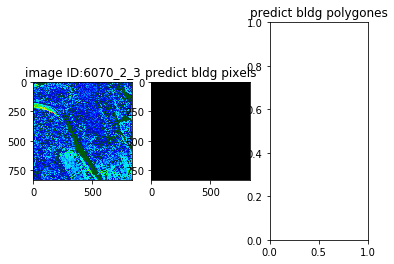

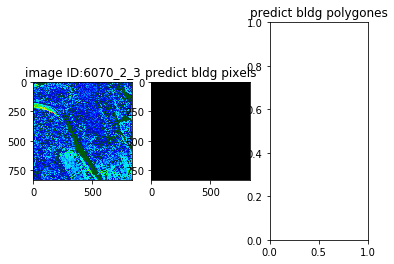

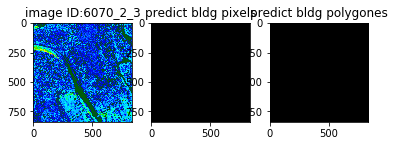

(960, 960, 10)


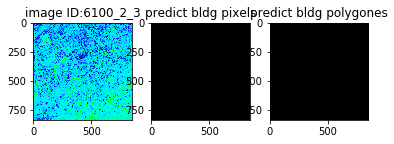

(960, 960, 10)


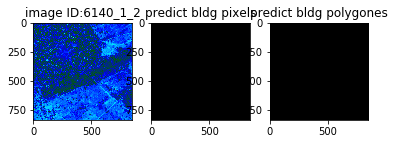

(960, 960, 10)


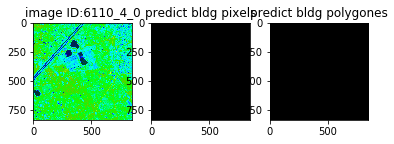

In [85]:
def predict_id(id, model, trs):
    # Read and preprocess
    img = M(id)
    
    x = stretch_n(img)

    ndvi, savi, evi, ndwi = create_indexes(id)
    x = np.concatenate((x, ndvi.reshape(ndvi.shape[0], ndvi.shape[1], 1)), -1)
    x = np.concatenate((x, ndwi.reshape(ndwi.shape[0], ndwi.shape[1], 1)), -1)
    
    cnv = np.zeros((960, 960, 10)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x
    print(cnv.shape)

    # NOTE 960/160 = 6
    # for each col of a full image
    for i in range(0, 6):
        line = []
        # predict each row of a full image at a time
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1 # Same sort of standardisation/normalisation as before (and th/tf ordering fix)
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]  # threshold 

    return prd[:, :img.shape[0], :img.shape[1]] # prediction for one image (and one class in my case)


#VAL data comparison
for i in range(1,5):
    trs = [0.5]
    check_predict(val_img_names[i], train_model=model_base)

"Probably due to a bug in the prediction/plotting code (tweaked to try make work with additional bands)"

### Does loss = 1-jaccard work?

In [80]:
def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)
    

def get_unet_M8_NDVI_NDWI_jaccard_loss():
    inputs = Input((8+2, ISZ, ISZ))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=0.01), loss=jaccard_coef_loss, 
                  metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [81]:
model = get_unet_M8_NDVI_NDWI_jaccard_loss()

In [82]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 77 samples, validate on 85 samples
Epoch 1/1
77/77 [==============================] - 194s - loss: 0.8491 - jaccard_coef: 0.1509 - jaccard_coef_int: 0.2870 - acc: 0.4509 - val_loss: 0.8385 - val_jaccard_coef: 0.1615 - val_jaccard_coef_int: 0.1615 - val_acc: 0.6418


In [83]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 77 samples, validate on 85 samples
Epoch 1/1
77/77 [==============================] - 193s - loss: 0.8318 - jaccard_coef: 0.1682 - jaccard_coef_int: 0.1682 - acc: 0.6401 - val_loss: 0.8385 - val_jaccard_coef: 0.1615 - val_jaccard_coef_int: 0.1615 - val_acc: 0.6418


In [84]:
model.fit(x_trn, y_trn, batch_size=64, epochs=5, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 77 samples, validate on 85 samples
Epoch 1/5
77/77 [==============================] - 193s - loss: 0.8318 - jaccard_coef: 0.1682 - jaccard_coef_int: 0.1682 - acc: 0.6401 - val_loss: 0.8385 - val_jaccard_coef: 0.1615 - val_jaccard_coef_int: 0.1615 - val_acc: 0.6418
Epoch 2/5
77/77 [==============================] - 193s - loss: 0.8318 - jaccard_coef: 0.1682 - jaccard_coef_int: 0.1682 - acc: 0.6401 - val_loss: 0.8385 - val_jaccard_coef: 0.1615 - val_jaccard_coef_int: 0.1615 - val_acc: 0.6418
Epoch 3/5
77/77 [==============================] - 193s - loss: 0.8318 - jaccard_coef: 0.1682 - jaccard_coef_int: 0.1682 - acc: 0.6401 - val_loss: 0.8385 - val_jaccard_coef: 0.1615 - val_jaccard_coef_int: 0.1615 - val_acc: 0.6418
Epoch 4/5
77/77 [==============================] - 193s - loss: 0.8318 - jaccard_coef: 0.1682 - jaccard_coef_int: 0.1682 - acc: 0.6401 - val_loss: 0.8385 - val_jaccard_coef: 0.1615 - val_jaccard_coef_int: 0.1615 - val_acc: 0.6418
Epoch 5/5
77/77 [===================

Indeed, no learning has occurred due to the lack of differentiabilty of the loss function (I believe the first epoch is different to the rest as after the first epoch, the gradient may have been computed as 0, so the resulting updates are all based on this).

### Add batch norm to try reduce overfitting

Comparing to https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/mnist.ipynb BatchNorm layer add before most "major" layers. https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/statefarm-sample.ipynb is similar, as is https://deepsense.io/wp-content/uploads/2017/04/architecture_details.png. (Makes sense as is normalising the inputs).

(Interestingly the winner used batch norm before most layers on the encoder part, whilst the decode part uses dropout before.)

NOTE: I've omitted batchnorm from the input as the baseline code performs some standardisation/normalisation

In [9]:
def get_unet_M8_NDVI_NDWI_batchnorm():
    inputs = Input((8+2, ISZ, ISZ))

    model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', 
                  metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [10]:
x_val, y_val = np.load(inDir + '/data/x_val_%d.npy' % N_Cls), np.load(inDir + '/data/y_val_%d.npy' % N_Cls)
img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

# del x_trn
# del y_trn
x_trn, y_trn = get_patches(img, msk, amt=600, aug=False)

model = get_unet_M8_NDVI_NDWI_batchnorm()

Add blank, idx=7, count=1
Add blank, idx=18, count=2
Add blank, idx=23, count=3
Add blank, idx=24, count=4
Add blank, idx=69, count=5
Add blank, idx=75, count=6
Add blank, idx=81, count=7
Add blank, idx=84, count=8
Add blank, idx=114, count=9
Add blank, idx=125, count=10
Add blank, idx=128, count=11
Add blank, idx=131, count=12
Add blank, idx=143, count=13
Add blank, idx=155, count=14
Add blank, idx=170, count=15
Add blank, idx=194, count=16
Add blank, idx=237, count=17
Add blank, idx=297, count=18
Add blank, idx=316, count=19
Add blank, idx=319, count=20
Add blank, idx=328, count=21
Add blank, idx=334, count=22
Add blank, idx=361, count=23
Add blank, idx=394, count=24
Add blank, idx=397, count=25
Add blank, idx=403, count=26
Add blank, idx=413, count=27
Add blank, idx=416, count=28
Add blank, idx=448, count=29
Add blank, idx=449, count=30
Add blank, idx=452, count=31
Add blank, idx=457, count=32
Add blank, idx=462, count=33
Add blank, idx=477, count=34
Add blank, idx=481, count=35
Add

In [11]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/1
94/94 [==============================] - 349s - loss: 0.6121 - jaccard_coef: 0.1731 - jaccard_coef_int: 0.1628 - acc: 0.6731 - val_loss: 2.7487 - val_jaccard_coef: 0.0156 - val_jaccard_coef_int: 0.0155 - val_acc: 0.8262


In [12]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(x_trn, y_trn, batch_size=64, epochs=15, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/15
94/94 [==============================] - 346s - loss: 0.4952 - jaccard_coef: 0.1821 - jaccard_coef_int: 0.1422 - acc: 0.8223 - val_loss: 2.6030 - val_jaccard_coef: 2.4864e-05 - val_jaccard_coef_int: 2.4859e-05 - val_acc: 0.8385
Epoch 2/15
94/94 [==============================] - 346s - loss: 0.3581 - jaccard_coef: 0.2612 - jaccard_coef_int: 0.2374 - acc: 0.8452 - val_loss: 2.6690 - val_jaccard_coef: 0.0064 - val_jaccard_coef_int: 0.0064 - val_acc: 0.8343
Epoch 3/15
94/94 [==============================] - 345s - loss: 0.2819 - jaccard_coef: 0.3505 - jaccard_coef_int: 0.3475 - acc: 0.8686 - val_loss: 2.6341 - val_jaccard_coef: 0.0035 - val_jaccard_coef_int: 0.0035 - val_acc: 0.8366
Epoch 4/15
94/94 [==============================] - 346s - loss: 0.2807 - jaccard_coef: 0.3352 - jaccard_coef_int: 0.2899 - acc: 0.8663 - val_loss: 10.7132 - val_jaccard_coef: 0.1536 - val_jaccard_coef_int: 0.1536 - val_acc: 0.3284
Epoch 5/15
94/94 [=====

In [13]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/1
94/94 [==============================] - 346s - loss: 0.2325 - jaccard_coef: 0.4072 - jaccard_coef_int: 0.4925 - acc: 0.8997 - val_loss: 13.3603 - val_jaccard_coef: 0.1615 - val_jaccard_coef_int: 0.1615 - val_acc: 0.1615


In [14]:
K.set_value(model.optimizer.lr, 0.1)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/1
94/94 [==============================] - 345s - loss: 0.4522 - jaccard_coef: 0.3707 - jaccard_coef_int: 0.4336 - acc: 0.8556 - val_loss: 7.1893 - val_jaccard_coef: 0.1452 - val_jaccard_coef_int: 0.1437 - val_acc: 0.4629


In [15]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/1
94/94 [==============================] - 346s - loss: 0.4599 - jaccard_coef: 0.3074 - jaccard_coef_int: 0.4296 - acc: 0.7345 - val_loss: 6.1613 - val_jaccard_coef: 0.1455 - val_jaccard_coef_int: 0.1399 - val_acc: 0.4336


In [16]:
K.set_value(model.optimizer.lr, 0.001)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/1
94/94 [==============================] - 351s - loss: 0.4525 - jaccard_coef: 0.3074 - jaccard_coef_int: 0.4324 - acc: 0.7414 - val_loss: 4.4931 - val_jaccard_coef: 0.1449 - val_jaccard_coef_int: 0.1392 - val_acc: 0.3857


In [23]:
K.set_value(model.optimizer.lr, 0.001)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/1
94/94 [==============================] - 346s - loss: 0.3902 - jaccard_coef: 0.3210 - jaccard_coef_int: 0.4523 - acc: 0.7765 - val_loss: 3.0522 - val_jaccard_coef: 0.1434 - val_jaccard_coef_int: 0.1371 - val_acc: 0.3479


In [24]:
K.set_value(model.optimizer.lr, 0.001)
model.fit(x_trn, y_trn, batch_size=64, epochs=3, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/3
94/94 [==============================] - 346s - loss: 0.3512 - jaccard_coef: 0.3313 - jaccard_coef_int: 0.4597 - acc: 0.8017 - val_loss: 2.3599 - val_jaccard_coef: 0.1332 - val_jaccard_coef_int: 0.1347 - val_acc: 0.3249
Epoch 2/3
94/94 [==============================] - 346s - loss: 0.3191 - jaccard_coef: 0.3404 - jaccard_coef_int: 0.4648 - acc: 0.8157 - val_loss: 2.0458 - val_jaccard_coef: 0.1190 - val_jaccard_coef_int: 0.1239 - val_acc: 0.3328
Epoch 3/3
94/94 [==============================] - 346s - loss: 0.3024 - jaccard_coef: 0.3422 - jaccard_coef_int: 0.4589 - acc: 0.8209 - val_loss: 1.9323 - val_jaccard_coef: 0.1086 - val_jaccard_coef_int: 0.1113 - val_acc: 0.3725


In [25]:
K.set_value(model.optimizer.lr, 0.001)
model.fit(x_trn, y_trn, batch_size=64, epochs=3, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/3
94/94 [==============================] - 346s - loss: 0.3005 - jaccard_coef: 0.3344 - jaccard_coef_int: 0.4548 - acc: 0.8327 - val_loss: 1.9026 - val_jaccard_coef: 0.1040 - val_jaccard_coef_int: 0.1080 - val_acc: 0.3958
Epoch 2/3
94/94 [==============================] - 346s - loss: 0.2962 - jaccard_coef: 0.3308 - jaccard_coef_int: 0.4340 - acc: 0.8319 - val_loss: 1.8685 - val_jaccard_coef: 0.1039 - val_jaccard_coef_int: 0.1091 - val_acc: 0.4271
Epoch 3/3
94/94 [==============================] - 345s - loss: 0.3105 - jaccard_coef: 0.3184 - jaccard_coef_int: 0.4082 - acc: 0.8500 - val_loss: 1.7720 - val_jaccard_coef: 0.1054 - val_jaccard_coef_int: 0.1119 - val_acc: 0.4829


In [26]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/1
94/94 [==============================] - 346s - loss: 0.2814 - jaccard_coef: 0.3410 - jaccard_coef_int: 0.4590 - acc: 0.8523 - val_loss: 1.7947 - val_jaccard_coef: 0.1067 - val_jaccard_coef_int: 0.1119 - val_acc: 0.4852


In [40]:
K.set_value(model.optimizer.lr, 0.001)
model.fit(x_trn, y_trn, batch_size=64, epochs=3, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/3
94/94 [==============================] - 346s - loss: 0.2883 - jaccard_coef: 0.3338 - jaccard_coef_int: 0.4433 - acc: 0.8544 - val_loss: 1.6920 - val_jaccard_coef: 0.1066 - val_jaccard_coef_int: 0.1119 - val_acc: 0.5437
Epoch 2/3
94/94 [==============================] - 346s - loss: 0.2781 - jaccard_coef: 0.3419 - jaccard_coef_int: 0.4676 - acc: 0.8613 - val_loss: 1.6393 - val_jaccard_coef: 0.1036 - val_jaccard_coef_int: 0.1073 - val_acc: 0.5853
Epoch 3/3
94/94 [==============================] - 346s - loss: 0.2835 - jaccard_coef: 0.3383 - jaccard_coef_int: 0.4489 - acc: 0.8679 - val_loss: 1.6096 - val_jaccard_coef: 0.0980 - val_jaccard_coef_int: 0.0998 - val_acc: 0.6119


In [ ]:
#VAL data comparison
for i in range(1,5):
    check_predict(val_img_names[i], train_model=model)

m(8)+NDWI+NDVI with no batch norm still best - what about the 3rd place loss?

## New loss

In [57]:
import math

def jaccard_approx(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    binary_cross_entropy = K.sum(y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred), axis=[0, -1, -2])  # may need to change 1 to a np array
    
    N = int(y_pred.shape[2] * y_pred.shape[3])
    
    jaccard_approximation = 1/N * jac
    
    return binary_cross_entropy - K.log(jaccard_approximation)

In [58]:
def get_unet_M8_NDVI_NDWI_newloss():
    inputs = Input((8+2, ISZ, ISZ))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=0.01), loss=jaccard_approx, 
                  metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [59]:
model_newloss = get_unet_M8_NDVI_NDWI_newloss()

In [60]:
K.set_value(model_newloss.optimizer.lr, 0.01)
model_newloss.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 94 samples, validate on 85 samples
Epoch 1/1
94/94 [==============================] - 223s - loss: nan - jaccard_coef: 0.1557 - jaccard_coef_int: 0.0375 - acc: 0.4834 - val_loss: nan - val_jaccard_coef: nan - val_jaccard_coef_int: nan - val_acc: 0.6418


Hmmm...that doesn't look promising - lets see if passing some y_true=y_pred yeilds ~ 0

In [63]:
x_val.shape

(85, 10, 160, 160)

In [67]:
a = model.predict(x_val[0].reshape(1, x_val.shape[1], x_val.shape[2], x_val.shape[3]))

In [70]:
a.shape

(1, 1, 160, 160)

In [72]:
jaccard_approx(a, a)

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

# M(3) + NDVI + NDWI with best performing model (i.e. standard baseline) - "Occam Razor"

In [88]:
def make_val(aug=False):
    print("let's pick some samples for validation")
    img = np.load(inDir + '/data/x_valALL_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_valALL_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=300, aug=aug)  # amt := attempt (maybe - i.e. attempting to create 3000 patches, without
                                            # percentage area cover threshold.

    print("Validation data shapes:")
    print(x.shape)
    print(y.shape)

    np.save(inDir + '/data/x_val_%d' % N_Cls, x)
    np.save(inDir + '/data/y_val_%d' % N_Cls, y)
    
    
def stick_all_train():
    print("let's stick all imgs together")
    s = 835  # size of the M images (roughly)

    # 25 training images grid
    x = np.zeros((5 * s, 4 * s, 3+2))      # (3,4,5 + ndvi + ndwi)
    y = np.zeros((5 * s, 4 * s, N_Cls))  # axis=2 denote the class label

    ids = sorted(DF.ImageId.unique())
    print(len(ids))
    
    
    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(4):
            id = ids[4 * i + j]

            img = M(id)
        
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            
            x[s * i:s * i + s, s * j:s * j + s, 0] = img[:s, :s, 3]
            x[s * i:s * i + s, s * j:s * j + s, 1] = img[:s, :s, 4]
            x[s * i:s * i + s, s * j:s * j + s, 2] = img[:s, :s, 5]
            
            # Add indexes from above
            ndvi, savi, evi, ndwi = create_indexes(id)
            x[s * i:s * i + s, s * j:s * j + s, 3] = ndvi[:s, :s]
            x[s * i:s * i + s, s * j:s * j + s, 4] = ndwi[:s, :s]   
            
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]
    
    print("x shape is:")
    print(x.shape)
    print("y shape is:")
    print(y.shape)

    print(np.amax(y), np.amin(y))
    
    np.save(inDir + '/data/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/data/y_trn_%d' % N_Cls, y)
    
    
def stick_all_val():
    print("let's stick all imgs together")
    s = 835  # size of the M images

    # 25 training images grid
    x = np.zeros((5 * s, 1 * s, 3+2))      # (3,4,5 + ndvi + ndwi)
    y = np.zeros((5 * s, 1 * s, N_Cls))   # axis=2 denote the class label

    ids = sorted(val_DF.ImageId.unique())
    print(len(ids))

    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(1):
            id = ids[1 * i + j]

            img = M(id)
            
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            
            x[s * i:s * i + s, s * j:s * j + s, 0] = img[:s, :s, 3]
            x[s * i:s * i + s, s * j:s * j + s, 1] = img[:s, :s, 4]
            x[s * i:s * i + s, s * j:s * j + s, 2] = img[:s, :s, 5]
            
            # Add indexes from above
            ndvi, savi, evi, ndwi = create_indexes(id)
            x[s * i:s * i + s, s * j:s * j + s, 3] = ndvi[:s, :s]
            x[s * i:s * i + s, s * j:s * j + s, 4] = ndwi[:s, :s]  
            
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1, wkt_list_pandas=val_DF)[:s, :s]

    print("x shape is:")
    print(x.shape)
    print("y shape is:")
    print(y.shape)

    print(np.amax(y), np.amin(y))

    np.save(inDir + '/data/x_valALL_%d' % N_Cls, x)
    np.save(inDir + '/data/y_valALL_%d' % N_Cls, y)

In [89]:
stick_all_train()

stick_all_val()
make_val()

let's stick all imgs together
20
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
x shape is:
(4175, 3340, 5)
y shape is:
(4175, 3340, 1)
1.0 0.0
let's stick all imgs together
5
(837, 848, 8) 6010_4_4 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
x shape is:
(4175, 835, 5)
y shape is:
(4175, 835, 1)
1.0 0.0
let's pick some samples for validation
Add blank, idx=5, count=1
Add blank, idx=9, count=2
Add blank, idx=29, count=3
Add blank, 

In [90]:
def get_unet_M3_NDVI_NDWI():
    inputs = Input((3+2, ISZ, ISZ))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', 
                  metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [91]:
x_val, y_val = np.load(inDir + '/data/x_val_%d.npy' % N_Cls), np.load(inDir + '/data/y_val_%d.npy' % N_Cls)
img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

model = get_unet_M3_NDVI_NDWI()

In [94]:
del x_trn
del y_trn
x_trn, y_trn = get_patches(img, msk, amt=600, aug=False)

Add blank, idx=25, count=1
Add blank, idx=57, count=2
Add blank, idx=117, count=3
Add blank, idx=138, count=4
Add blank, idx=290, count=5
Add blank, idx=297, count=6
Add blank, idx=299, count=7
Add blank, idx=314, count=8
Add blank, idx=323, count=9
Add blank, idx=333, count=10
Add blank, idx=392, count=11
Add blank, idx=411, count=12
Add blank, idx=426, count=13
Add blank, idx=540, count=14
Add blank, idx=547, count=15
(61, 5, 160, 160) (61, 1, 160, 160) 1.0 -2.24008345604 1.0 0.0


In [95]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 61 samples, validate on 84 samples
Epoch 1/1
61/61 [==============================] - 167s - loss: 0.7303 - jaccard_coef: 0.2419 - jaccard_coef_int: 0.5341 - acc: 0.2944 - val_loss: 0.6872 - val_jaccard_coef: 0.1511 - val_jaccard_coef_int: 0.0884 - val_acc: 0.6599


In [96]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 61 samples, validate on 84 samples
Epoch 1/1
61/61 [==============================] - 172s - loss: 0.6838 - jaccard_coef: 0.2267 - jaccard_coef_int: 0.0904 - acc: 0.6894 - val_loss: 2.8770 - val_jaccard_coef: 5.7418e-18 - val_jaccard_coef_int: 5.7418e-18 - val_acc: 0.8215


In [97]:
K.set_value(model.optimizer.lr, 0.1)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 61 samples, validate on 84 samples
Epoch 1/1
61/61 [==============================] - 165s - loss: 4.7439 - jaccard_coef: 2.1758e-18 - jaccard_coef_int: 2.1758e-18 - acc: 0.7057 - val_loss: 2.8770 - val_jaccard_coef: 5.7418e-18 - val_jaccard_coef_int: 5.7418e-18 - val_acc: 0.8215


In [98]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 61 samples, validate on 84 samples
Epoch 1/1
61/61 [==============================] - 165s - loss: 4.7439 - jaccard_coef: 2.1758e-18 - jaccard_coef_int: 2.1758e-18 - acc: 0.7057 - val_loss: 2.8770 - val_jaccard_coef: 5.7418e-18 - val_jaccard_coef_int: 5.7418e-18 - val_acc: 0.8215


In [99]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(x_trn, y_trn, batch_size=64, epochs=3, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 61 samples, validate on 84 samples
Epoch 1/3
61/61 [==============================] - 165s - loss: 4.7439 - jaccard_coef: 2.1758e-18 - jaccard_coef_int: 2.1758e-18 - acc: 0.7057 - val_loss: 2.8770 - val_jaccard_coef: 5.7418e-18 - val_jaccard_coef_int: 5.7418e-18 - val_acc: 0.8215
Epoch 2/3
61/61 [==============================] - 165s - loss: 4.7439 - jaccard_coef: 2.1758e-18 - jaccard_coef_int: 2.1758e-18 - acc: 0.7057 - val_loss: 2.8770 - val_jaccard_coef: 5.7418e-18 - val_jaccard_coef_int: 5.7418e-18 - val_acc: 0.8215
Epoch 3/3
61/61 [==============================] - 165s - loss: 4.7439 - jaccard_coef: 2.1758e-18 - jaccard_coef_int: 2.1758e-18 - acc: 0.7057 - val_loss: 2.8770 - val_jaccard_coef: 5.7418e-18 - val_jaccard_coef_int: 5.7418e-18 - val_acc: 0.8215


Not unsuprisingly, more signal in all 8 bands.